In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:

# Phys 375 final project coding for equations  
# Note: This version of the code does not include Beren's latest bisection algorithm!

# Packages
import numpy as np
from numpy import pi, array, linspace, log10
from math import sqrt, exp
import astropy.constants as const
import matplotlib.pyplot as plt

#vvvvvvvvvv Control Panel vvvvvvvvvv#
# Use these variables to turn on and off plots
pressure_plot = False 
dlogP_dlogT_plot = False
log_opacity_plot = False # Opacity plot doesn't work!
luminosity_gradient_plot = False
dens_temp_mass_lum_plot = False

# Print which plots will be shown
print("The following plots will be displayed:")
if not(pressure_plot or dlogP_dlogT_plot or log_opacity_plot or luminosity_gradient_plot or dens_temp_mass_lum_plot):
    print("None")
else:
    if pressure_plot:
        print("Pressure vs Radius")
    if dlogP_dlogT_plot:
        print("dlogP/dlogT vs Radius")
    if log_opacity_plot:
        print("log(opacity) vs Radius")
    if luminosity_gradient_plot:
        print("dL/dr vs Radius")
    if dens_temp_mass_lum_plot:
        print("rho, T, M, L vs Radius")

#^^^^^^^^^^ Control Panel ^^^^^^^^^^#

#vvvvvvvvvv Global Variables vvvvvvvvvv#
# WARNING, THESE ARE GLOBAL VARIABLES!!! 
# They're supposed to be constants!
# So please do not modify them!
# Universal Constants
G = const.G.value
k_B = const.k_B.value
m_p = const.m_p.value
m_e = const.m_e.value
M_sun = const.M_sun.value
L_sun = const.L_sun.value
sigma_sb = const.sigma_sb.value
h_bar = const.hbar.value
c = const.c.value
# Hydrogen, Helium, and Metals proportion constants (idk where these came from, a friend just told me these values)
X = 0.734
Y = 0.25
Z = 0.016
# Other common constants
mu = (2*X + 0.75*Y + 0.5*Z)**(-1) # Mean molecular weight
a = 4 * sigma_sb/c # From Lec 9a slide 10
gamma = 5/3 # I have no idea what gamma is supposed to be Lec 9a slide 11 had this value.
# ^^^^^^^^^^ Global Variables ^^^^^^^^^^#


##################################################################
###################### Function Definitions ######################
#vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv#
# Where possible, please order the natural variables described at the end of pg 1 like this: 
    # (rho, T, M, L)
# Unless otherwise indicated, assume that the contract for each function is
    # listof(floats) -> float 

# Scientific Notation
# Turns a float into a string, 
# the string is the scientific notation representation of that float
def scinot(num, sigfigs = 3): 
    # float, int -> string
    return("{:.{}e}".format(num, sigfigs))


# equation 25
# let r_b = blackhole radius, 
# L_b = blackhole luminosity,
# temp_c = central temperature, 
# and rho_c = central density
def black_hole(L_b, mu, mp, c, k, temp_c, rho_c):
    r_b = sqrt((L_b*mu*mp)/(4*pi*c*k*temp_c*rho_c))
    return r_b

def drho_dr(r,rho,T,M,L):
    return -((dP_dr(rho,M,r))+((dP_dr(rho,T))*(dT_dr(r, rho, T, M, L))))/(dP_drho(rho,T))


# Equation 24
# Beren Last edited on Mar 24 11AM EDT
# Function: L_dot(M_dot)
# Contract: float -> float
# The function calculates the corresponding eddington luminosity given M_dot
# The constant M of the sun is imported from package astropy
# Unit: Watt

def L_dot(M_dot):
    Ldot = 1.3*10**31*(M_dot / M_sun.value)
    return Ldot

# Equation 4
# Calculating luminosity using radius and temperature
# Contract: float, float -> float
def L(R_star, T_star):
  return 4*np.pi*sigma_sb*R_star**2*T_star**4


# Equation 17
# Beren Last edited on Mar 29 9PM EDT
# Function: f(M_dot)
# Contract: float -> float
# Error function, need to be minimized by bisection method (suggest scipy.optimize.bisect)
# The constant sigma is imported from package astropy
# Input: L_s, R_s, T_s denotes the values at the surface

def f(L_s,R_s,T_s):
    return (L_s - 4*np.pi*sigma_sb.value*R_s**2*T_s**4)/np.sqrt(4*np.pi*sigma_sb.value*R_s**2*T_s**4*L_s)


# Beren Last edited on Mar 24 11AM EDT
# Function: L_dot(M_dot)
# Contract: float -> float
# The function calculates the corresponding eddington luminosity given M_dot
# The constant M of the sun is imported from package astropy
# Unit: Watt

def L_dot(M_dot):
    Ldot = 1.3*10**31*(M_dot / M_sun.value)
    return Ldot


# Skye tends to put independent variable first when defining ODEs
#vvvvv Stellar Structure ODEs eq (1,2) vvvvv# 
# Density Gradient
def drho_dr(r, rho, T, M, L):
    A = const.G.value * M * rho/r**2
    B = dP_dT(rho, T) * dT_dr(r, rho, T, M, L)
    C = dP_drho(rho, T)
    return -(A + B)/C

# Temperature Gradient
def dT_dr(r, rho, T, M, L):
    A = 3 * kappa(rho, T) * rho * L/(16 * pi * a * const.c.value * T**3 * r**2)
    B = (1 - 1/gamma) * T/P(rho, T) * const.G.value * M * rho/r**2
    return -min(A,B)

# Mass Gradient
def dM_dr(r, rho):
    return 4 * pi * r**2 * rho

# Luminosity Gradient
def dL_dr(r, rho, T):
    return 4 * pi * r**2 * rho * epsilon(rho, T)

# Opacity Gradient:
def dtau_dr(rho, T):
    return kappa(rho, T) * rho

# Pressure Gradient
def dP_dr(r, rho, M):
    return -const.G.value * M * rho/r**2

# The Vector DE to be solved numerically
def dy_dr(r, y): # returns a vector of derivatives that need to be solved together
    # Contract and notes about this function:
        # (float, [floats]) -> [floats]
    # vec = [rho, T, M, L, tau]
    # returned_value looks like: [drho, dT, dM, dL, dtau]
    # So technically, the function looks like this:
        # dy_dr(r, [rho, T, M, L, dtau]) -> [drho, dT, dM, dL, dtau]

    rho = y[0]
    T = y[1]
    M = y[2]
    L = y[3]
    return array(  [drho_dr(r, rho, T, M, L),
                    dT_dr(r, rho, T, M, L),
                    dM_dr(r, rho),
                    dL_dr(r, rho, T),
                    dtau_dr(rho, T)])
#^^^^^ Stellar Structure ODEs eq (1,2) ^^^^^# 



#vvvvv Pressure eq (5) vvvvv# 
def P(rho, T):    
    A = (3 * pi**2)**(2/3)/5
    B = const.hbar.value**2/(const.m_e.value)
    C = rho/const.m_p.value
    D = rho * const.k_B.value * T/(mu * const.m_p.value)
    E = 1/3 * a * T**4
    return A*B*C**(5/3) + D + E
#^^^^^ Pressure eq (5) ^^^^^# 


#vvvvv Important PDEs eq (7) vvvvv# 
# Density derivative of Pressure
def dP_drho(rho, T):
    A = (3 * pi**2)**(2/3)/3
    B = const.hbar.value**2/(const.m_e.value * const.m_p.value)
    C = rho/const.m_p.value
    D = const.k_B.value * T / (mu * const.m_p.value)
    return A * B * C**(2/3) + D

# Temperature derivative of Pressure
def dP_dT(rho, T):
    A = rho * const.k_B.value/(mu * const.m_p.value)
    B = 4/3 * a * T**3
    return A + B
#^^^^^ Important PDEs eq (7) ^^^^^#


#vvvvv Total Specific Energy Generation Rate eq (8,9) vvvvv# 
def epsilon(rho, T): 
    # Other important local constants (see pg 3 of project description)
    rho_5 = rho/1e5 # kg/m**3
    T_6 = T/1e6 # K
    X_CNO = 0.03*X

    # Eq (8)
    epsilon_PP = 1.07e-7 * rho_5 * X**2 * T_6**4 # W/kg
    epsilon_CNO = 8.24e-26 * rho_5 * X * X_CNO * T_6**19.9 # W/kg

    # Actual calculation of eq (9)
    return epsilon_PP + epsilon_CNO # W/kg
#^^^^^ Total Specific Energy Generation Rate ^^^^^#

#vvvvv Opacity Equations eq (10 - 14) vvvvv# 
# Eq (14) The important radiative opacity equation
def kappa(rho, T):
    # Important local constant (see pg 3 of project description)
    rho_3 = rho/1e3 # kg/m**3

    # Eq (10)
    kappa_es = 0.02 * (1 + X) # m**2/kg

    # Eq (11)
    kappa_ff = 1.0e24 * (Z + 0.0001) * rho_3**(0.7) * T**(-3.5) # m**2/kg
    
    # Eq (12)
    kappa_H = 2.5e-32 * (Z/0.02) * rho_3**(0.5) * T**9 # m**2/kg

    # The actual computation of eq (14)
    A = 1/kappa_H
    B = 1/max(kappa_es, kappa_ff)
    return (A + B)**(-1)
#^^^^^ Opacity Equations eq (10 - 14) ^^^^^#


# codys start to the code
# Opacity Error eq (16) 
def delta_tau(r, rho, T, M, L):
    A = kappa(rho, T)
    B = rho
    C = abs( drho_dr(r, rho, T, M, L) )
    return A * B**2 / C
# codys end of the code

#vvvvv Integration Function vvvvv#
###### Josh 3/10
# integrate for rho, T, M, L, tau
# step size of 2e5 should be fine. finishes in ~3500 iterations for the sun
# max_M_solar (solar mass limit) and iter_limit are both conditions for stopping integration (along with delta_tau)
# the default values should be fine for stars similar to the sun, but may need to be increased for larger central temperatures.
#
# returns dictionary with trial solution values, and values at surface.
#  also returns a boolean indicating "overshot", which means that either the mass limit or iter_limit were reached
#  if overshot, then increase rho_c
#
# tips:
#   - behaviour highly sensitive to rho_c, so don't be surprised by crazy "solutions"
#   - if rho_c too small -> temperature does not decrease fast enough
def integrate(rho_c, T_c, step_size_init = None, max_M_solar=30, iter_limit=10000, silent=False):
    
    # default value. this works well
    if step_size_init is None:
        step_size_init = 2e6 * (T_c/5e6)
    
    # Take 1 step using RK4, given derivative function f
    def RK4_step(y, r, f, step_size):
        h = step_size
        k1 = f(r, y)
        
        y1 = y+h*k1/2
        if (y1 <= 0).any():
            return None
        k2 = f(r + h/2, y1)
        
        y2 = y+h*k2/2
        if (y2 <= 0).any():
            return None
        k3 = f(r + h/2, y2)
        
        y3 = y + h*k3
        if (y3 <= 0).any():
            return None
        k4 = f(r + h, y3)
        
        ret =y + 1/6 * h * (k1 + 2 * k2 + 2 * k3 + k4)
        if (ret <= 0).any():
            return None
        return ret
    
    # set initial conditions on some small r0, for numerical stability
    r0 = step_size_init
    step_size = step_size_init
    
    r = r0
    rho = rho_c
    T = T_c
    M = 4/3 * np.pi * r0**3 * rho_c
    L = 4/3 * np.pi * r0**3 * rho_c * epsilon(rho_c, T_c)
    tau = kappa(rho, T) * rho * r0
    y = np.array([rho, T, M, L, tau])
    r_l, y_l = [r], [y]
    
    cnt = 0
    while delta_tau(r, y[0], y[1], y[2], y[3]) > 0.01 and y[2] < max_M_solar * const.M_sun.value:
        y = RK4_step(y, r, dy_dr, step_size)
        while y is None:
            step_size /= 2
            y = RK4_step(y_l[-1], r, dy_dr, step_size)
        r = r + step_size
        step_size = min(step_size, y[1]/T_c * step_size_init)
        r_l.append(r)
        y_l.append(y)
        cnt += 1
        if cnt >= iter_limit:
            break
            
        if y[0] < rho_c*0.05 and y[1] > T_c * 0.4:
            break
    if not silent:
        print(f"Completed in {cnt} iterations")
    
    overshot = delta_tau(r, y[0], y[1], y[2], y[3]) > 1e-2
    
    r, y = np.array(r_l), np.array(y_l)
    rho = y[:, 0]
    T = y[:, 1]
    M = y[:, 2]
    L = y[:, 3]
    tau = y[:, 4]
    
    # index where tau is first greater than the last value - 2/3
    idx = np.argmax(tau > tau[-1] - 2/3)
    def interpolate(v1, v2, z):
        return z*v1 + (1-z)*v2
    
    z = (2/3) / (tau[idx]-tau[idx-1])
    rs = interpolate(r[idx-1], r[idx], z)
    rhos = interpolate(rho[idx-1], rho[idx], z)
    Ts = interpolate(T[idx-1], T[idx], z)
    Ms = interpolate(M[idx-1], M[idx], z)
    Ls = interpolate(L[idx-1], L[idx], z)
    taus = tau[idx-1]-2/3
    
    return {
        "values": (r, rho, T, M, L, tau),
        "surface": (rs, rhos, Ts, Ms, Ls, taus),
        "overshot": overshot
    }
#^^^^^ Integration Function ^^^^^#

## Integration Function for Thorne-Zytkow Objects ##
def integrate_tz(rho_c, T_c, Mdot, step_size_init = None, max_M_solar=30, iter_limit=5000, silent=False):
    
    # default value. this works well
    if step_size_init is None:
        step_size_init = 2e6 * (T_c/5e6)
    
    # Take 1 step using RK4, given derivative function f
    def RK4_step(y, r, f, step_size):
        h = step_size
        k1 = f(r, y)
        
        y1 = y+h*k1/2
        if (y1 <= 0).any():
            return None
        k2 = f(r + h/2, y1)
        
        y2 = y+h*k2/2
        if (y2 <= 0).any():
            return None
        k3 = f(r + h/2, y2)
        
        y3 = y + h*k3
        if (y3 <= 0).any():
            return None
        k4 = f(r + h, y3)
        
        ret =y + 1/6 * h * (k1 + 2 * k2 + 2 * k3 + k4)
        if (ret <= 0).any():
            return None
        return ret

    
    Ldot = 1.3e31 * Mdot/const.M_sun.value
    rdot = 1e7 * np.sqrt(Ldot * mu * const.m_p.value / (4 * np.pi * const.c.value * const.k_B.value * T_c * rho_c))
    
    r = rdot
    rho = rho_c
    T = T_c
    M = Mdot
    L = Ldot
    tau = 0
    y = np.array([rho, T, M, L, tau])
    r_l, y_l = [r], [y]
    step_size = step_size_init
    
    cnt = 0
    while delta_tau(r, y[0], y[1], y[2], y[3]) > 0.01 and y[2] < max_M_solar * const.M_sun.value:
        y = RK4_step(y, r, dy_dr, step_size)
        while y is None:
            step_size /= 2
            y = RK4_step(y_l[-1], r, dy_dr, step_size)
        r = r + step_size
        r_l.append(r)
        y_l.append(y)
        step_size = min(step_size, y[1]/T_c * step_size_init)
        
        cnt += 1
        if cnt >= iter_limit:
            break
            
        if y[0] < rho_c*0.05 and y[1] > T_c * 0.4:
            break
    if not silent:
        print(f"Completed in {cnt} iterations")
    
    overshot = delta_tau(r, y[0], y[1], y[2], y[3]) > 1e-2
    
    r, y = np.array(r_l), np.array(y_l)
    rho = y[:, 0]
    T = y[:, 1]
    M = y[:, 2]
    L = y[:, 3]
    tau = y[:, 4]
    
    # index where tau is first greater than the last value - 2/3
    idx = np.argmax(tau > tau[-1] - 2/3)
    def interpolate(v1, v2, z):
        return z*v1 + (1-z)*v2
    
    z = (2/3) / (tau[idx]-tau[idx-1])
    rs = interpolate(r[idx-1], r[idx], z)
    rhos = interpolate(rho[idx-1], rho[idx], z)
    Ts = interpolate(T[idx-1], T[idx], z)
    Ms = interpolate(M[idx-1], M[idx], z)
    Ls = interpolate(L[idx-1], L[idx], z)
    taus = tau[idx-1]-2/3
    
    return {
        "values": (r, rho, T, M, L, tau),
        "surface": (rs, rhos, Ts, Ms, Ls, taus),
        "overshot": overshot
    }

## the bisection function I (Josh) used.
# the l and r parameters are the lower and upper bound for the rho_c range - using the default values is fine
# use silent=True to make it shut up and not print many lines
# Example use:
# bisection(1e7, const.M_sun.value * 1e-5, silent=True)
def bisection(T_c, Mdot, l=1e3, r=1e6, silent=False):
    f=100
    prevmid = 0
    while abs(f)>0.1 or (r-l)/((l+r)/2) > 1e-5:
        mid = (l+r)/2
        if (r-l)/((l+r)/2) < 1e-8:
            return r
        v = integrate_tz(mid, T_c, Mdot, silent=silent)
        r_s, rho_s, T_s, M_s, L_s, tau_s = v["surface"]
        t = 4*np.pi*r_s**2*const.sigma_sb.value*T_s**4
        f = np.log10(L_s)-np.log10(t)
        if f < 0:
            l = mid
        else:
            r = mid
        if not silent:
            print(mid, f)
    return mid



The following plots will be displayed:
None


In [ ]:
arr = np.loadtxt("main_sequence.txt")
# these are numpy arrays of length 29 (for 29 stars)
rho_c, T_c, M, R, L_s, T_s = arr.T

Text(0.5, 0, '$M/M_\\odot$')

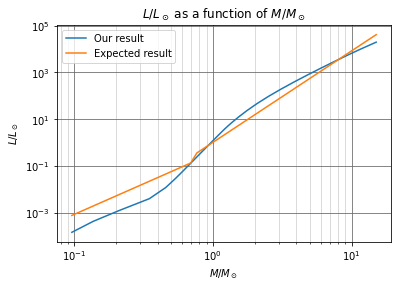

In [ ]:
LtoLsun = L_s / L_sun
MtoMsun = M / M_sun

LexpectedtoLsun = []
for i in range(len(MtoMsun)):
  if M[i] < (0.7 * M_sun):
    LexpectedtoLsun.append(0.35 * (MtoMsun[i])**2.62)
  else:
    LexpectedtoLsun.append(1.02 * (MtoMsun[i])**3.92)


plt.loglog(MtoMsun, LtoLsun, label = "Our result")
plt.loglog(MtoMsun, LexpectedtoLsun, label = "Expected result")
plt.legend()

# Gridlines
plt.minorticks_on()
plt.grid(True, which='major', color = "dimgrey")
plt.grid(True, which='minor', color = "lightgrey")

# Labels
plt.title("$L/L_\odot$ as a function of $M/M_\odot$")
plt.ylabel("$L/L_\odot$")
plt.xlabel("$M/M_\odot$")

Text(0.5, 0, '$M/M_\\odot$')

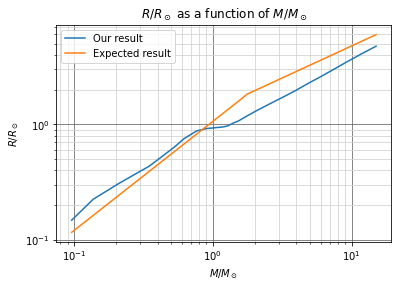

In [ ]:
RtoRsun = R / const.R_sun.value
MtoMsun = M / const.M_sun.value

RexpectedtoRsun = []
for i in range(len(MtoMsun)):
  if M[i] < (1.66 * M_sun):
    RexpectedtoRsun.append(1.06 * (MtoMsun[i])**0.945)
  else:
    RexpectedtoRsun.append(1.33 * (MtoMsun[i])**0.555)

plt.loglog(MtoMsun, RtoRsun, label = "Our result")
plt.loglog(MtoMsun, RexpectedtoRsun, label = "Expected result")
plt.legend()

# Gridlines
plt.minorticks_on()
plt.grid(True, which='major', color = "dimgrey")
plt.grid(True, which='minor', color = "lightgrey")

# Labels
plt.title("$R/R_\odot$ as a function of $M/M_\odot$")
plt.ylabel("$R/R_\odot$")
plt.xlabel("$M/M_\odot$")

In [ ]:
T_c[25]

27000000.0

In [ ]:
rho_c_lst = rho_c
T_c_lst = T_c

In [ ]:
## Generating all variant main sequences example:

# core_masses = const.M_sun.value * np.logspace(-9, -2, 8)
# central_temps = np.linspace(2e6, 30e6, 15)
# data = []
# for Mdot in core_masses:
#     print(Mdot / const.M_sun.value)
#     for T_c in central_temps:
#         rho_c = bisection(T_c, Mdot, 1e3, 1e6, silent=True)
#         data.append((Mdot, rho_c, T_c))
#         print(T_c, rho_c)

## the data list will contain tuples of Mdot, rho_c, T_c.
# use integrate_tz(rho_c, T_c, Mdot) to get the full list of internal features and surface values

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^#
###################### Function Definitions ######################
##################################################################


#vvvvvvvvvvvvvvvvvvvvvvvvvvv PLOTTING vvvvvvvvvvvvvvvvvvvvvvvvvvv# 
# Write out all variables that we're plotting
rho_c, T_c = rho_c_lst[4], T_c_lst[4]
output_dic = integrate(rho_c, T_c)
r = output_dic["values"][0]
rho = output_dic["values"][1]
T = output_dic["values"][2]
M = output_dic["values"][3]
L = output_dic["values"][4]
tau = output_dic["values"][5]
R_s = max(r)
r_Rs = list(r/R_s)

#vvvvv Plotting Pressure vs Radius vvvvv#
# Degenerate Pressure
def P_degen(rho):
    A = (3 * pi**2)**(2/3)/5
    B = const.hbar.value**2/(const.m_e.value)
    C = rho/const.m_p.value
    return A*B*C**(5/3) 

# Ideal Gas Pressure
def P_gas(rho, T):
    return rho * k_B * T/(mu * m_p)

# Photon Gas Pressure
def P_photon(T):
    return 1/3 * a * T**4

# Total Pressure
P_tot = P(rho, T)

# Normalization constant
P_c = max(P_tot)

if (pressure_plot):
    # Plot each line
    plt.plot(r/R_s, P_tot/P_c, 'k-', label = r"$P_{tot}$")
    plt.plot(r/R_s, P_degen(rho)/P_c, 'r--', label = r"Non-relativistic Degenerate, $P_{deg}$")
    plt.plot(r/R_s, P_gas(rho, T)/P_c, 'g--', label = r"Ideal Gas, $P_{gas}$")
    plt.plot(r/R_s, P_photon(T)/P_c, 'b--', label = r"Photon Gas, $P_{\gamma}$")
    plt.legend()

    # Gridlines
    plt.minorticks_on()
    plt.grid(True, which='major', color = "dimgrey")
    plt.grid(True, which='minor', color = "lightgrey")

    # Viewing Window
    plt.xlim(0,1)
    plt.ylim(0,1)

    # Labels
    plt.title(r"Normalized Pressure of a Star for $(\rho_c, T_c) = ({}, {})$".format(scinot(rho_c), scinot(T_c)))
    plt.xlabel(r"Radius, $r/R_s$")
    plt.ylabel(r"Pressure, $P/P_c$")
    plt.show()
#^^^^^ Plotting Pressure vs Radius ^^^^^#


#vvvvv /Begin/ Plotting dlogP/dlogT vs Radius vvvvv#
if(dlogP_dlogT_plot):
    # calculating values needed
    logP = np.log10(P_tot)
    logT = np.log10(T)
    dlogP = []
    dlogT = []
    dlogP_dlogT = []
    for i in range(len(T)-1):
        dlogP.append(logP[i+1] - logP[i])
        dlogT.append(logT[i+1] - logT[i])
        dlogP_dlogT.append(dlogP[i]/dlogT[i])

    # Plotting
    plt.plot(r_Rs[0:len(r)-1], dlogP_dlogT, 'k-')

    # Gridlines
    plt.minorticks_on()
    plt.grid(True, which='major', color = "dimgrey")
    plt.grid(True, which='minor', color = "lightgrey")

    # Viewing Window
    plt.xlim(0,1)
    plt.ylim(0,8)

    # Labels
    plt.title(r"dlogP/dlogT of a Star for $(\rho_c, T_c) = ({}, {})$".format(scinot(rho_c), scinot(T_c)))
    plt.xlabel(r"$r/R_s$")
    plt.ylabel(r"dlogP/dlogT")
    plt.show()
#^^^^^ /End/ Plotting dlogP/dlogT vs Radius ^^^^^#


#vvvvv /Begin/ Plotting log(opacity) vs Radius vvvvv#
# Opacity plot doesn't work!
if(log_opacity_plot):
    # calculating values needed
    # Important local constant (see pg 3 of project description)
    rho_3 = rho/1e3 # kg/m**3
    log_kappa_es = log10([0.02 * (1 + X)]*len(r_Rs))
    log_kappa_ff = log10(1.0e24 * (Z + 0.0001) * rho_3**(0.7) * T**(-3.5)) # m**2/kg
    log_kappa_H = log10(2.5e-32 * (Z/0.02) * rho_3**(0.5) * T**9) # m**2/kg
    opacity = list(map(kappa, rho, T))
    log_opacity = np.log10(opacity)

    # Plotting
    plt.plot(r_Rs, log_kappa_es, 'b--', label = r"$\kappa_{es}$")
    plt.plot(r_Rs, log_kappa_ff, 'g--', label = r"$\kappa_{ff}$")
    plt.plot(r_Rs, log_kappa_H, 'r--', label = r"$\kappa_{H}$")
    plt.plot(r_Rs, log_opacity, 'k--', label = r"$\kappa$")
    plt.legend()

    # Gridlines
    plt.minorticks_on()
    plt.grid(True, which='major', color = "dimgrey")
    plt.grid(True, which='minor', color = "lightgrey")

    # Viewing Window
    # plt.xlim(0,1)
    # plt.ylim(0,8)

    # Labels
    plt.title(r"log(Opacity) of a Star for $(\rho_c, T_c) = ({}, {})$".format(scinot(rho_c), scinot(T_c)))
    plt.xlabel(r"$Radius, r/R_s$")
    plt.ylabel(r"$Opacity, \log_{10}(\kappa)$")
    plt.show()
#^^^^^ /End/ Plotting log(opacity) vs Radius ^^^^^#

#vvvvv Plotting dL_dr vs R/R. vvvvv#
if luminosity_gradient_plot:
    # Luminosity
    R_s = max(r)
    M_s = max(M)
    L_s = max(L)

    # Luminosity from p-p chain
    def dLpp_dr(rho,T,r):
        p5 = rho/1e5
        temp6 = T/1e6
        e_pp = (1.07e-7)*(X**2)*p5*(temp6**4)#am i using the right X values?
        dLpp_dr = 4*pi*(r**2)*rho*e_pp
        return dLpp_dr

    # Luminosity from cno chain
    def dLcno_dr(rho,T,r):
        p5 = rho/1e5
        temp6 = T/1e6
        X_CNO = 0.03*X
        e_cno = (8.24e-26)*(X*X_CNO)*(p5)*(temp6**19.9)
        dLcno_dr = 4*pi*(r**2)*rho*e_cno
        return dLcno_dr

    # Plot each line
    plt.plot(r/R_s, dL_dr(r, rho, T)/(L_s/R_s), 'k-', label = "dL/dr")
    plt.plot(r/R_s, dLpp_dr(rho,T,r)/(L_s/R_s), 'r--', label = "dL_pp/dr")
    plt.plot(r/R_s, dLcno_dr(rho,T,r)/(L_s/R_s), 'g--', label = "dL_cno/dr")
    plt.legend()

    # Gridlines
    plt.minorticks_on()
    plt.grid(True, which='major', color = "dimgrey")
    plt.grid(True, which='minor', color = "lightgrey")

    # Viewing Window
    plt.xlim(0,1)
    plt.ylim(0,10)

    # Labels
    plt.title("Luminosity vs Radius")
    plt.xlabel("Radius r/Rs")
    plt.ylabel("Luminosity")
    plt.show()
#^^^^^ Plotting dL_dr vs R/R. ^^^^^#


#vvvvv Plotting rho, T, M, L vs R/R. vvvvv#
if dens_temp_mass_lum_plot:
    plt.plot(r/R_s, rho/max(rho), "k-", label = r"rho")
    plt.plot(r/R_s, T/max(T), "r--", label = r"T")
    plt.plot(r/R_s, M/max(M), "g--", label = r"M")
    plt.plot(r/R_s, L/max(L), "b--", label = r"L")
    plt.title("Normalizaed density, temperature, mass and luminosity of a main sequence star")
    plt.ylabel("rho/rho_c, T/T_c, M/M_dot, L/L_dot") 
    plt.legend()
    plt.minorticks_on()
    plt.grid(True, which='major', color = "dimgrey")
    plt.grid(True, which='minor', color = "lightgrey")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel(r"Radius, $r/R_s$")
    plt.show()
#^^^^^ Plotting rho, T, M, L vs R/R. ^^^^^#

#^^^^^^^^^^^^^^^^^^^^^^^^^^^ PLOTTING ^^^^^^^^^^^^^^^^^^^^^^^^^^^# 



#vvvvv Global constants modified detector vvvvv# START
# Detects whether or not constants were modified
def global_constant_modified():
    # void -> None 
    # Will output messages
    epsilon = 0.01
    if (G - const.G.value) > epsilon:
        print("WARNING, GLOBAL CONSTANT MODIFICATION DETECTED!!!")
        print("G has been modified")
    if (k_B - const.k_B.value) > epsilon:
        print("WARNING, GLOBAL CONSTANT MODIFICATION DETECTED!!!")
        print("k_B has been modified")
    if (m_p - const.m_p.value) > epsilon:
        print("WARNING, GLOBAL CONSTANT MODIFICATION DETECTED!!!")
        print("m_p has been modified")
    if (m_e - const.m_e.value) > epsilon:
        print("WARNING, GLOBAL CONSTANT MODIFICATION DETECTED!!!")
        print("m_e has been modified")
    if (M_sun - const.M_sun.value) > epsilon:
        print("WARNING, GLOBAL CONSTANT MODIFICATION DETECTED!!!")
        print("M_sun has been modified")
    if (sigma_sb - const.sigma_sb.value) > epsilon:
        print("WARNING, GLOBAL CONSTANT MODIFICATION DETECTED!!!")
        print("sigma_sb has been modified")
    if (h_bar - const.hbar.value) > epsilon:
        print("WARNING, GLOBAL CONSTANT MODIFICATION DETECTED!!!")
        print("h_bar has been modified")
    if (c - const.c.value) > epsilon:
        print("WARNING, GLOBAL CONSTANT MODIFICATION DETECTED!!!")
        print("c has been modified")
    if (X - 0.734) > epsilon:
        print("WARNING, GLOBAL CONSTANT MODIFICATION DETECTED!!!")
        print("X has been modified")
    if (Y - 0.25) > epsilon:
        print("WARNING, GLOBAL CONSTANT MODIFICATION DETECTED!!!")
        print("Y has been modified")
    if (Z - 0.016) > epsilon:
        print("WARNING, GLOBAL CONSTANT MODIFICATION DETECTED!!!")
        print("Z has been modified")
    if (mu - (2*X + 0.75*Y + 0.5*Z)**(-1)) > epsilon:
        print("WARNING, GLOBAL CONSTANT MODIFICATION DETECTED!!!")
        print("mu has been modified")
    if (a - (4 * sigma_sb/c)) > epsilon:
        print("WARNING, GLOBAL CONSTANT MODIFICATION DETECTED!!!")
        print("a has been modified")
    if (gamma - (5/3)) > epsilon:
        print("WARNING, GLOBAL CONSTANT MODIFICATION DETECTED!!!")
        print("gamma has been modified")
# TEMPLATE
# if (_variable_ - (_value_)) > epsilon:
#     print("WARNING, GLOBAL CONSTANT MODIFICATION DETECTED!!!")
#     print("_variable_ has been modified")
global_constant_modified()
#^^^^^ Global constants modified detector ^^^^^# END

Completed in 1755 iterations


Completed in 3328 iterations


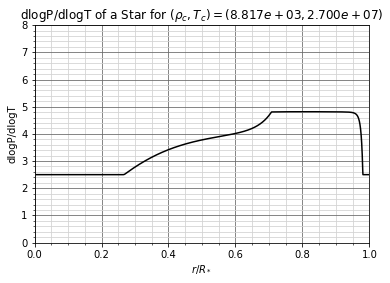

In [ ]:
index = 25
rho_c, T_c = rho_c_lst[index], T_c_lst[index]
output_dic = integrate(rho_c, T_c)
r = output_dic["values"][0]
rho = output_dic["values"][1]
T = output_dic["values"][2]
M = output_dic["values"][3]
L = output_dic["values"][4]
tau = output_dic["values"][5]
R_s = max(r)
r_Rs = list(r/R_s)

# Total Pressure
P_tot = P(rho, T)

# Normalization constant
P_c = max(P_tot)


'''
plt.plot(r/R_s, rho/max(rho), "k-", label = r"$\rho$")
plt.plot(r/R_s, T/max(T), "r--", label = r"T")
plt.plot(r/R_s, M/max(M), "g--", label = r"M")
plt.plot(r/R_s, L/max(L), "b--", label = r"L")
plt.title("Normalized density, temperature, mass and luminosity of Star 1")
plt.ylabel(r"$\rho$ / $\rho_c$, $T/T_c$, $M/M_*$, $L/L_*$") 
plt.legend()
plt.minorticks_on()
plt.grid(True, which='major', color = "dimgrey")
plt.grid(True, which='minor', color = "lightgrey")
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel(r"Radius, $r/R_*$")
plt.show()
'''
'''
# Total Pressure
P_tot = P(rho, T)

# Normalization constant
P_c = max(P_tot)

plt.plot(r/R_s, P_tot/P_c, 'k-', label = r"$P_{tot}$")
plt.plot(r/R_s, P_degen(rho)/P_c, 'r--', label = r"Non-relativistic Degenerate, $P_{deg}$")
plt.plot(r/R_s, P_gas(rho, T)/P_c, 'g--', label = r"Ideal Gas, $P_{gas}$")
plt.plot(r/R_s, P_photon(T)/P_c, 'b--', label = r"Photon Gas, $P_{\gamma}$")
plt.legend()

# Gridlines
plt.minorticks_on()
plt.grid(True, which='major', color = "dimgrey")
plt.grid(True, which='minor', color = "lightgrey")

# Viewing Window
plt.xlim(0,1)
plt.ylim(0,1)

# Labels
plt.title(r"Normalized Pressure of a Star for $(\rho_c, T_c) = ({}, {})$".format(scinot(rho_c), scinot(T_c)))
plt.xlabel(r"Radius, $r/R_*$")
plt.ylabel(r"Pressure, $P/P_c$")
plt.show()
'''
'''
rho_3 = rho/1e3 # kg/m**3
log_kappa_es = log10([0.02 * (1 + X)]*len(r_Rs))
log_kappa_ff = log10(1.0e24 * (Z + 0.0001) * rho_3**(0.7) * T**(-3.5)) # m**2/kg
log_kappa_H = log10(2.5e-32 * (Z/0.02) * rho_3**(0.5) * T**9) # m**2/kg
opacity = list(map(kappa, rho, T))
log_opacity = np.log10(opacity)

# Plotting
plt.plot(r_Rs, log_kappa_es, 'b--', label = r"$\kappa_{es}$")
plt.plot(r_Rs, log_kappa_ff, 'g--', label = r"$\kappa_{ff}$")
plt.plot(r_Rs, log_kappa_H, 'r--', label = r"$\kappa_{H}$")
plt.plot(r_Rs, log_opacity, 'k--', label = r"$\kappa$")
plt.legend()

# Gridlines
plt.minorticks_on()
plt.grid(True, which='major', color = "dimgrey")
plt.grid(True, which='minor', color = "lightgrey")

# Viewing Window
# plt.xlim(0,1)
# plt.ylim(0,8)

# Labels
plt.title(r"log(Opacity) of a Star for $(\rho_c, T_c) = ({}, {})$".format(scinot(rho_c), scinot(T_c)))
plt.xlabel(r"$Radius, r/R_*$")
plt.ylabel(r"$Opacity, \log_{10}(\kappa)$")
plt.show()
'''
'''
#^^^^^ Plotting dL_dr vs R/R. ^^^^^#
# Luminosity
R_s = max(r)
M_s = max(M)
L_s = max(L)

# Luminosity from p-p chain
def dLpp_dr(rho,T,r):
    p5 = rho/1e5
    temp6 = T/1e6
    e_pp = (1.07e-7)*(X**2)*p5*(temp6**4)#am i using the right X values?
    dLpp_dr = 4*pi*(r**2)*rho*e_pp
    return dLpp_dr

# Luminosity from cno chain
def dLcno_dr(rho,T,r):
    p5 = rho/1e5
    temp6 = T/1e6
    X_CNO = 0.03*X
    e_cno = (8.24e-26)*(X*X_CNO)*(p5)*(temp6**19.9)
    dLcno_dr = 4*pi*(r**2)*rho*e_cno
    return dLcno_dr

# Plot each line
plt.plot(r/R_s, dL_dr(r, rho, T)/(L_s/R_s), 'k-', label = "$dL/dr$")
plt.plot(r/R_s, dLpp_dr(rho,T,r)/(L_s/R_s), 'r--', label = "$dL_{pp}/dr$")
plt.plot(r/R_s, dLcno_dr(rho,T,r)/(L_s/R_s), 'g--', label = "$dL_{cno}/dr$")
plt.legend()

# Gridlines
plt.minorticks_on()
plt.grid(True, which='major', color = "dimgrey")
plt.grid(True, which='minor', color = "lightgrey")

# Viewing Window
plt.xlim(0,1)
plt.ylim(0,10)

# Labels
plt.title("dL/dr vs Radius")
plt.xlabel("Radius $r/R_*$")
plt.ylabel("dL/dr")
plt.show()
#^^^^^ Plotting dL_dr vs R/R. ^^^^^#
'''

logP = np.log10(P_tot)
logT = np.log10(T)
dlogP = []
dlogT = []
dlogP_dlogT = []
for i in range(len(T)-1):
    dlogP.append(logP[i+1] - logP[i])
    dlogT.append(logT[i+1] - logT[i])
    dlogP_dlogT.append(dlogP[i]/dlogT[i])

# Plotting
plt.plot(r_Rs[0:len(r)-1], dlogP_dlogT, 'k-')

# Gridlines
plt.minorticks_on()
plt.grid(True, which='major', color = "dimgrey")
plt.grid(True, which='minor', color = "lightgrey")

# Viewing Window
plt.xlim(0,1)
plt.ylim(0,8)

# Labels
plt.title(r"dlogP/dlogT of a Star for $(\rho_c, T_c) = ({}, {})$".format(scinot(rho_c), scinot(T_c)))
plt.xlabel(r"$r/R_*$")
plt.ylabel(r"dlogP/dlogT")
plt.show()